# Transformer

参考:

* [Formal Algorithms for Transformers](https://arxiv.org/abs/2207.09238): シンプルなpseudocodeをまとめた論文。
* [Attention Primer](https://github.com/greentfrapp/attention-primer)
* [Transformerの最前線](https://www.slideshare.net/SSII_Slides/ssii2022-ts1-transformer)

よく考えたらTransformerについて知らないので実装して確認します。Transformerは「任意の個数のベクトルを任意の個数のベクトルに変換するネットワーク」です。各アルゴリズムは論文を参照してください。

## 用語など

* Vocabulary: $[N_V]:= \{1, \dots, N_V\}$のIDによって識別される単語や文字の集合のこと。この単語や文字をTokenと呼ぶ。何をTokenにするかは色々工夫があるよ。
    * "My grandma makes the best apple pie."を単語レベルでTokenizationすると、"My", "grandma", ... になり、それぞれをVocabularyのIDに対応させます。
* Token embedding: Vocabularyの要素をベクトルに対応させます。例："grandma" -> ID[grandma] -> $\mathbb{R}^{d_e}$
* Positional embedding: Tokenの場所をベクトルに対応させます。例："My grandma makes ..." -> pos[grandma] はここでは２です -> $\mathbb{R}^{d_e}$


### Transformerの初歩

まずは適当なデータセットを作ってAttentionの確認をしてみましょう (参考：[Attention Primer](https://github.com/greentfrapp/attention-primer))。文字のカウントをするAttentionを考えます。例えば次のような入力と出力を考えます。


```python
Input:
['A'], ['B'], [' '], ['B'], ['C']
Output:
[[1], [2], [1]]
```

これは「文字列を文字の出現数に翻訳する」タスクなわけですね。
この場合Positional embeddingは不要なので、tokenのembedはtoken embeddingのみで考えます。

In [1]:
import numpy as np
import string


class Dataset:
	def __init__(self, max_len=10, vocab_size=3):
		self.max_len = max_len
		self.vocab_size = vocab_size + 1
		self.vocab_embeds = np.eye(self.vocab_size)
		self.counts = np.eye(self.max_len + 1)
		assert self.vocab_size <= 26 + 1

	def next_batch(self, batchsize=100):
		# A, B, C, ... をone-hotにしたやつです
		sampled_tokens = self.vocab_embeds[np.random.choice(np.arange(self.vocab_size), [batchsize, self.max_len])]

		# カウント 0, 1, 2, ..., max_len をone-hotにしたやつです
		counts = np.sum(sampled_tokens, axis=1).astype(np.int32)
		sampled_counts = self.counts[counts]
		return sampled_tokens, sampled_counts

	def prettify(self, samples):
		samples = samples.reshape(-1, self.max_len, self.vocab_size)
		idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
		dictionary = np.array(list(' ' + string.ascii_uppercase))
		return dictionary[idx]


data = Dataset(5, 3)
data.next_batch(1)

(array([[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]]),
 array([[[0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]]]))

### Attention

Attentionは全n個のベクトルから全n個のベクトルへ情報を伝える処理になります（多分）。
CNNは近隣のみに情報を伝える処理、RNNは再帰的に情報を伝える処理であり、Attentionの方が広域に情報がロスなく伝達されます。
self-attentionでは入力のSequenceが一つですが、encoder-decoder attentionのように、異なるベクトルを入力にすることもできます。
今回はencoder-decoderを使います。

例えば上の例では、Inputである```[' '], ['A'], ['B'], ['C'] ```がクエリを投げ、Memory (context)である```['A'], ['B'], [' '], ['B'], ['C']```のどれにそれぞれが注目するかをキーで指定します。

In [169]:
import haiku as hk
import jax
import jax.numpy as jnp
from chex import Array
import chex


def build_pred(
    dim_out: int,
    dim_attn: int,
    dataset: Dataset,
) -> hk.Transformed:
    """単層のAttentionを作ります。また、どの文字が何個出力されたのか？も推論します"""

    vocab_seq = dataset.vocab_embeds
    length_vocab, dim_vocab = vocab_seq.shape
    length_count = dataset.max_len + 1

    @jax.vmap
    def forward(memory_seq: Array) -> Array:
        chex.assert_rank(memory_seq, 2)
        length_memory, dim_memory = memory_seq.shape

        # ----- attentionです -----

        # queryの計算
        W_q = hk.get_parameter("W_q", [dim_vocab, dim_attn], init=hk.initializers.RandomNormal())
        b_q = hk.get_parameter("b_q", [1, dim_attn], init=hk.initializers.RandomNormal())
        query = vocab_seq @ W_q + b_q
        chex.assert_shape(query, (length_vocab, dim_attn))

        # keyの計算
        W_k = hk.get_parameter("W_k", [dim_memory, dim_attn], init=hk.initializers.RandomNormal())
        b_k = hk.get_parameter("b_k", [1, dim_attn], init=hk.initializers.RandomNormal())
        key = memory_seq @ W_k + b_k
        chex.assert_shape(key, (length_memory, dim_attn))

        # valueの計算
        W_v = hk.get_parameter("W_v", [dim_memory, dim_out], init=hk.initializers.RandomNormal())
        b_v = hk.get_parameter("b_v", [1, dim_out], init=hk.initializers.RandomNormal())
        val = memory_seq @ W_v + b_v
        chex.assert_shape(val, (length_memory, dim_out))

        # scoreと重み付き和の計算
        score = (query @ key.T) / jnp.sqrt(dim_attn)
        weights = jax.nn.softmax(score, axis=-1)
        chex.assert_shape(weights, (length_vocab, length_memory))
        weighted_val = weights @ val
        chex.assert_shape(weighted_val, (length_vocab, dim_out))
        weighted_val = weighted_val
        weighted_val = hk.LayerNorm(axis=-1, create_scale=False, create_offset=False)(weighted_val)

        # ----- 文字カウントの推論 -----
        W_pred = hk.get_parameter("W_pred", [dim_out, length_count], init=hk.initializers.RandomNormal())
        pred = weighted_val @ W_pred
        chex.assert_shape(pred, (length_vocab, length_count))
        return weights, pred

    return hk.without_apply_rng(hk.transform(forward))


max_len = 5  # "全n個のベクトル"のn
vocab_size = 3
dataset = Dataset(max_len, vocab_size)

# attentionの準備
dim_out = dim_attn = 32
pred_count = build_pred(dim_out, dim_attn, dataset)
rng = jax.random.PRNGKey(0)
dummy_samples, dummy_labels = dataset.next_batch()
_params = pred_count.init(rng, dummy_samples)

# テスト
batchsize = 16
_samples, _labels = dataset.next_batch(batchsize)
attention, pred = pred_count.apply(_params, _samples)
chex.assert_shape(attention, (batchsize, dataset.vocab_size, dataset.max_len))
chex.assert_shape(pred, (batchsize, dataset.vocab_size, dataset.max_len + 1))

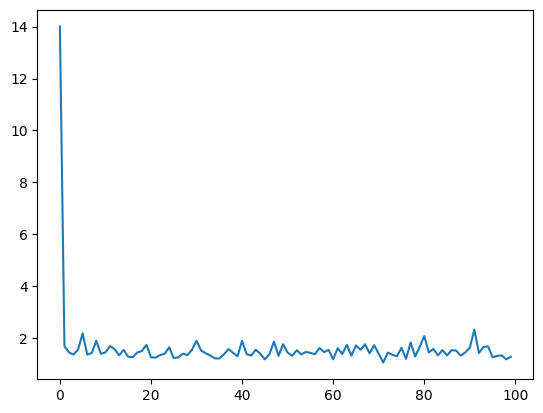

In [178]:
# 学習させてみます

import optax
import matplotlib.pyplot as plt

max_len = 10  # "全n個のベクトル"のn
vocab_size = 3
dataset = Dataset(max_len, vocab_size)

# 推論器の準備
dim_out = dim_attn = 64
pred_count = build_pred(dim_out, dim_attn, dataset)


# optimizerの準備
optimizer = optax.adam(1e-2)


def compute_loss(params, input_seqs, labels):
    _, preds = pred_count.apply(params, input_seqs)
    return jnp.mean(optax.softmax_cross_entropy(preds, labels))


@jax.jit
def compute_params(params, opt_state, input_seqs, labels):
    loss, grad = jax.value_and_grad(compute_loss)(params, input_seqs, labels)
    update, opt_state = optimizer.update(grad, opt_state, params)
    params = optax.apply_updates(params, update)
    return loss, params


rng = jax.random.PRNGKey(0)
dummy_samples, dummy_labels = dataset.next_batch()
params = pred_count.init(rng, dummy_samples)
opt_state = optimizer.init(params)


# 学習
batch_size = 100
losses = []
for i in range(10000):
    input_seqs, labels = dataset.next_batch(batchsize)
    loss, params = compute_params(params, opt_state, input_seqs, labels)
    if i % 100 == 0:
        losses.append(loss)

plt.plot(losses)

いい感じに学習できた気がします (意外とLayer Normが大事っぽい)。Attentionが何を見ているのか可視化してみましょう。

In [184]:
input_seq, label = dataset.next_batch(1)
attention, pred = pred_count.apply(params, input_seq)

label = label[0, :, :]
input_seq = input_seq[0, :, :]
attention = np.array(attention[0, :, :])
_pred = np.array(pred[0, :, :])
pred = np.zeros_like(_pred)
for i in range(pred.shape[0]):
    pred[i, _pred[i].argmax(-1)] = 1.0

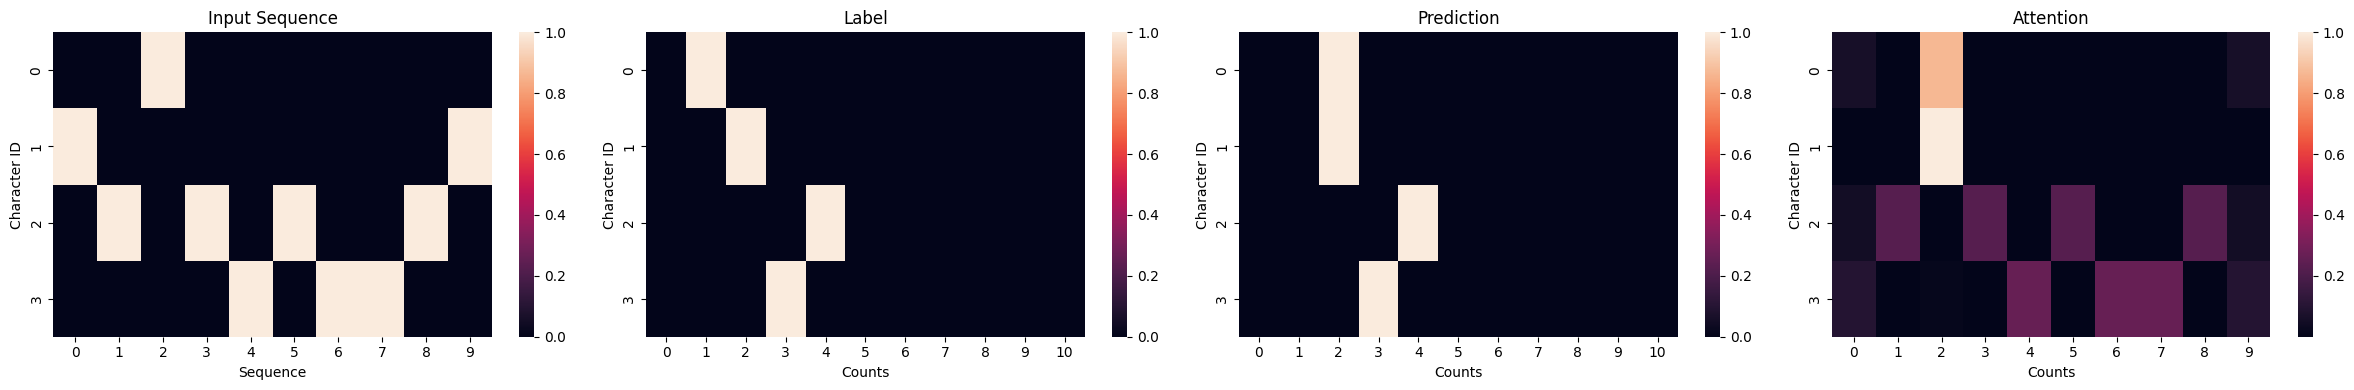

In [185]:
import seaborn as sns

plt.figure(figsize=(24, 4))

plt.subplot(1, 4, 1)
sns.heatmap(input_seq.T)
plt.ylabel("Character ID")
plt.xlabel("Sequence")
plt.title("Input Sequence")

plt.subplot(1, 4, 2)
sns.heatmap(label)
plt.ylabel("Character ID")
plt.xlabel("Counts")
plt.title("Label")

plt.subplot(1, 4, 3)
sns.heatmap(pred)
plt.ylabel("Character ID")
plt.xlabel("Counts")
plt.title("Prediction")


plt.subplot(1, 4, 4)
sns.heatmap(attention)
plt.ylabel("Character ID")
plt.xlabel("Counts")
plt.title(f"Attention")

plt.tight_layout()